In [1]:
%load_ext autoreload
%autoreload 2


In [3]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl
from scipy import sparse
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
import pickle

In [4]:
proj_name = "TabulaSapiens_n=300"
file_name = "TabulaSapiens_n=300"
file_suffix = time.strftime('%b%d-%H%M')
seed = 0

save_dir = Path(f"../save/{proj_name}-{file_suffix}")
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = Path(f"../data/{proj_name}")
data_dir.mkdir(parents=True, exist_ok=True)

ccd.ul.set_seed(seed)

In [ ]:
adata =  sc.read_h5ad(data_dir / f"{file_name}_final.h5ad")

In [ ]:
adata

# upload obsm from h5 file

In [7]:
import h5py

h5_path = "../save/obsm_concord-1.0.6_0.4-0.4_Jul15/obsm_TabulaSapiens_Jul18-1643.h5"

def print_h5_structure(g, prefix=""):
    for key in g.keys():
        item = g[key]
        if isinstance(item, h5py.Group):
            print(f"{prefix}{key}/ (Group)")
            print_h5_structure(item, prefix=prefix + key + "/")
        elif isinstance(item, h5py.Dataset):
            print(f"{prefix}{key:50s} shape: {item.shape}")

with h5py.File(h5_path, 'r') as f:
    print_h5_structure(f)

obsm/ (Group)
obsm/concord_hcl_UMAP                                   shape: (1134472, 2)
obsm/concord_knn_UMAP                                   shape: (1134472, 2)
obsm/contrastive_UMAP                                   shape: (1134472, 2)
obsm/harmony_UMAP                                       shape: (1134472, 2)
obsm/scvi_UMAP                                          shape: (1134472, 2)
obsm/unintegrated_UMAP                                  shape: (1134472, 2)


In [ ]:
# obsm_keys_to_copy = [
#     "contrastive_UMAP", "contrastive_UMAP_3D",
#     "harmony_UMAP", "harmony_UMAP_3D",
#     "scanorama_UMAP", "scanorama_UMAP_3D",
#     "scvi_UMAP", "scvi_UMAP_3D",
#     "unintegrated_UMAP", "unintegrated_UMAP_3D",
#     "liger_UMAP", "liger_UMAP_3D",
# ]
obsm_keys_to_copy = [
    "concord_hcl_UMAP", 
    "concord_knn_UMAP", 
    "contrastive_UMAP", 
    "harmony_UMAP", 
    "scvi_UMAP", 
    "unintegrated_UMAP", 
]

In [ ]:
with h5py.File(h5_path, 'r') as f:
    obsm_group = f['obsm']
    for key in obsm_keys_to_copy:
        if key in obsm_group:
            data = obsm_group[key][:]
            assert data.shape[0] == adata.n_obs, f"Shape mismatch for {key}"
            print(f"✅ Appending: {key}")
            adata.obsm[key] = data
        else:
            print(f"⚠️  Skipped (not found): {key}")

In [ ]:
adata.write(data_dir / f"{file_name}_final.h5ad")

In [ ]:
adata

----

# time and memory profiling

In [5]:
methods = ["liger", "harmony", "scanorama", "scvi", "contrastive", "concord_knn", "concord_hcl"]
# methods = ["unintegrated", "liger", "harmony", "scanorama", "scvi", "contrastive", "concord_knn", "concord_hcl"]

In [6]:
from benchmark_utils import collect_benchmark_logs
bench_df = collect_benchmark_logs(proj_name, methods)

[⚠️ Warning] no runs found for liger
[⚠️ Warning] no runs found for scanorama


In [8]:
for method in methods:
    if method not in bench_df['method'].values:
        new_row = pd.DataFrame([{
            'method': method,
        }])
        bench_df = pd.concat([bench_df, new_row], ignore_index=True)


In [45]:
bench_df

,method,gpu_name,time_sec,ram_MB,vram_MB
0,harmony,Tesla T4,274.218107,1420.695312,0.000000
1,scvi,Tesla T4,612.755747,3309.269531,81.356445
2,contrastive,Tesla T4,500.577508,3338.957031,180.185059
3,concord_knn,Tesla T4,565.636108,6374.937500,186.492188
4,concord_hcl,Tesla T4,589.043361,3432.125000,166.137207
5,liger,NaN,NaN,NaN,NaN
6,scanorama,NaN,NaN,NaN,NaN


✅ Benchmark summary saved to: ../save/TabulaSapiens_n=300-Jul23-2355/benchmark_summary_Jul23-2355.tsv


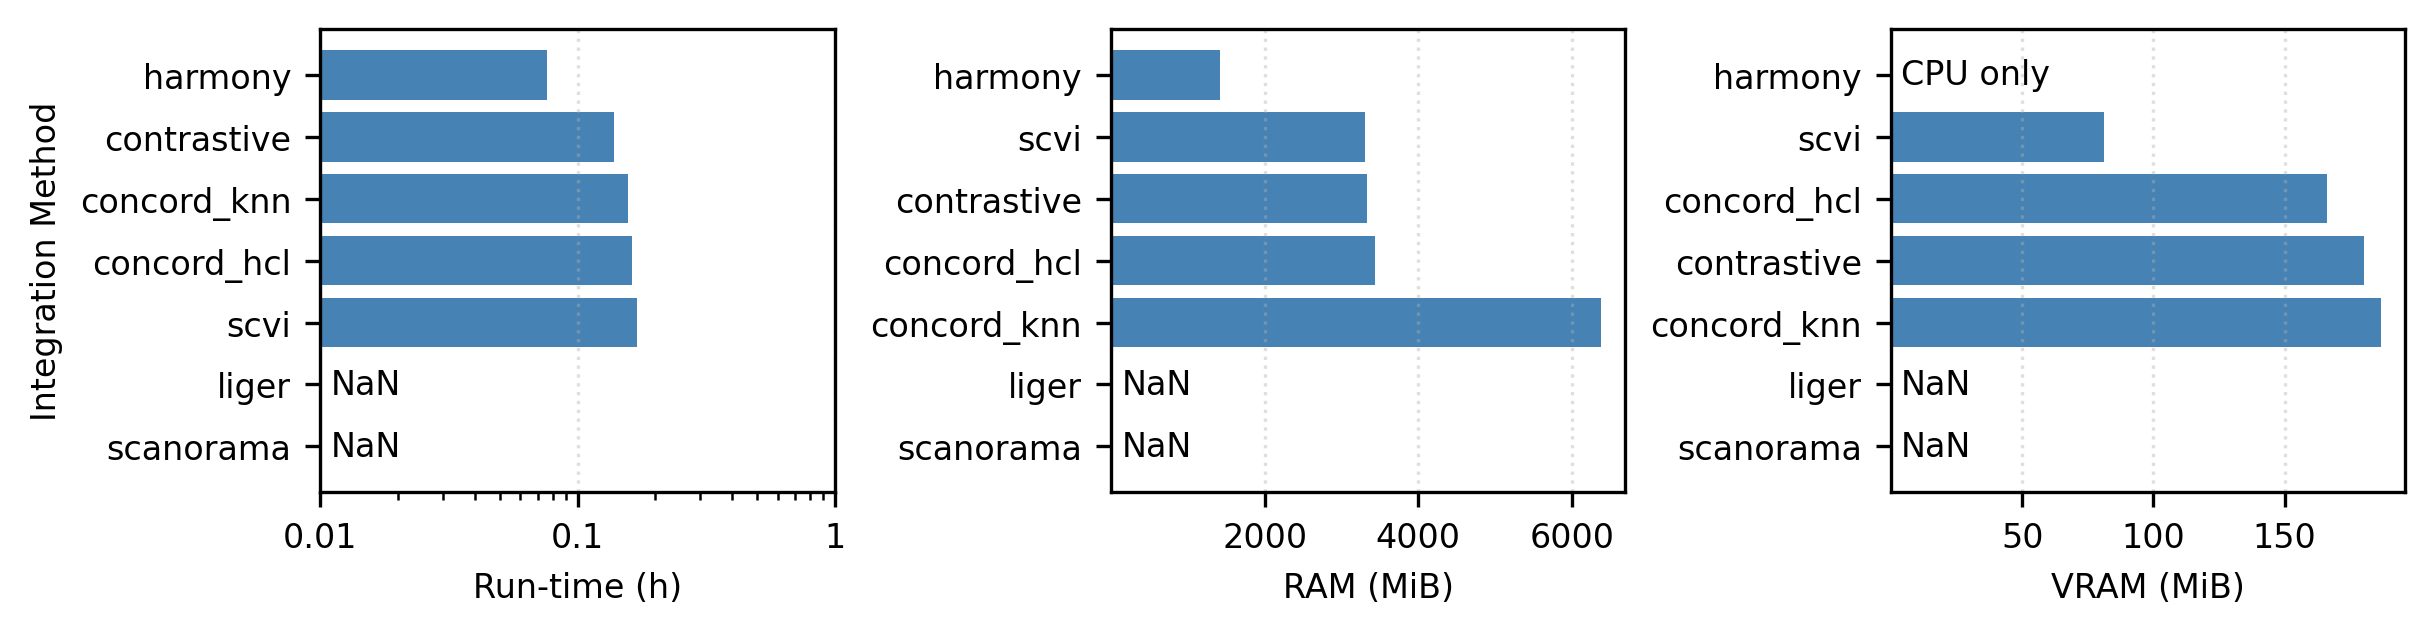

In [48]:
# Save the benchmark results
bench_df.to_csv(save_dir / f"benchmark_summary_{file_suffix}.tsv", sep="\t", index=False)
print(f"✅ Benchmark summary saved to: {save_dir / f'benchmark_summary_{file_suffix}.tsv'}")
# Plot benchmark results
from benchmark_utils import plot_benchmark_performance
import matplotlib.pyplot as plt
custom_rc = {
    'font.family': 'DejaVu Sans',  # Set the desired font for this plot
}
with plt.rc_context(rc=custom_rc):
    plot_benchmark_performance(bench_df, figsize=(8,2), dpi=300, 
                               save_path = save_dir / f"benchmark_plot_{file_suffix}.pdf",
                               label_fontsize=8)


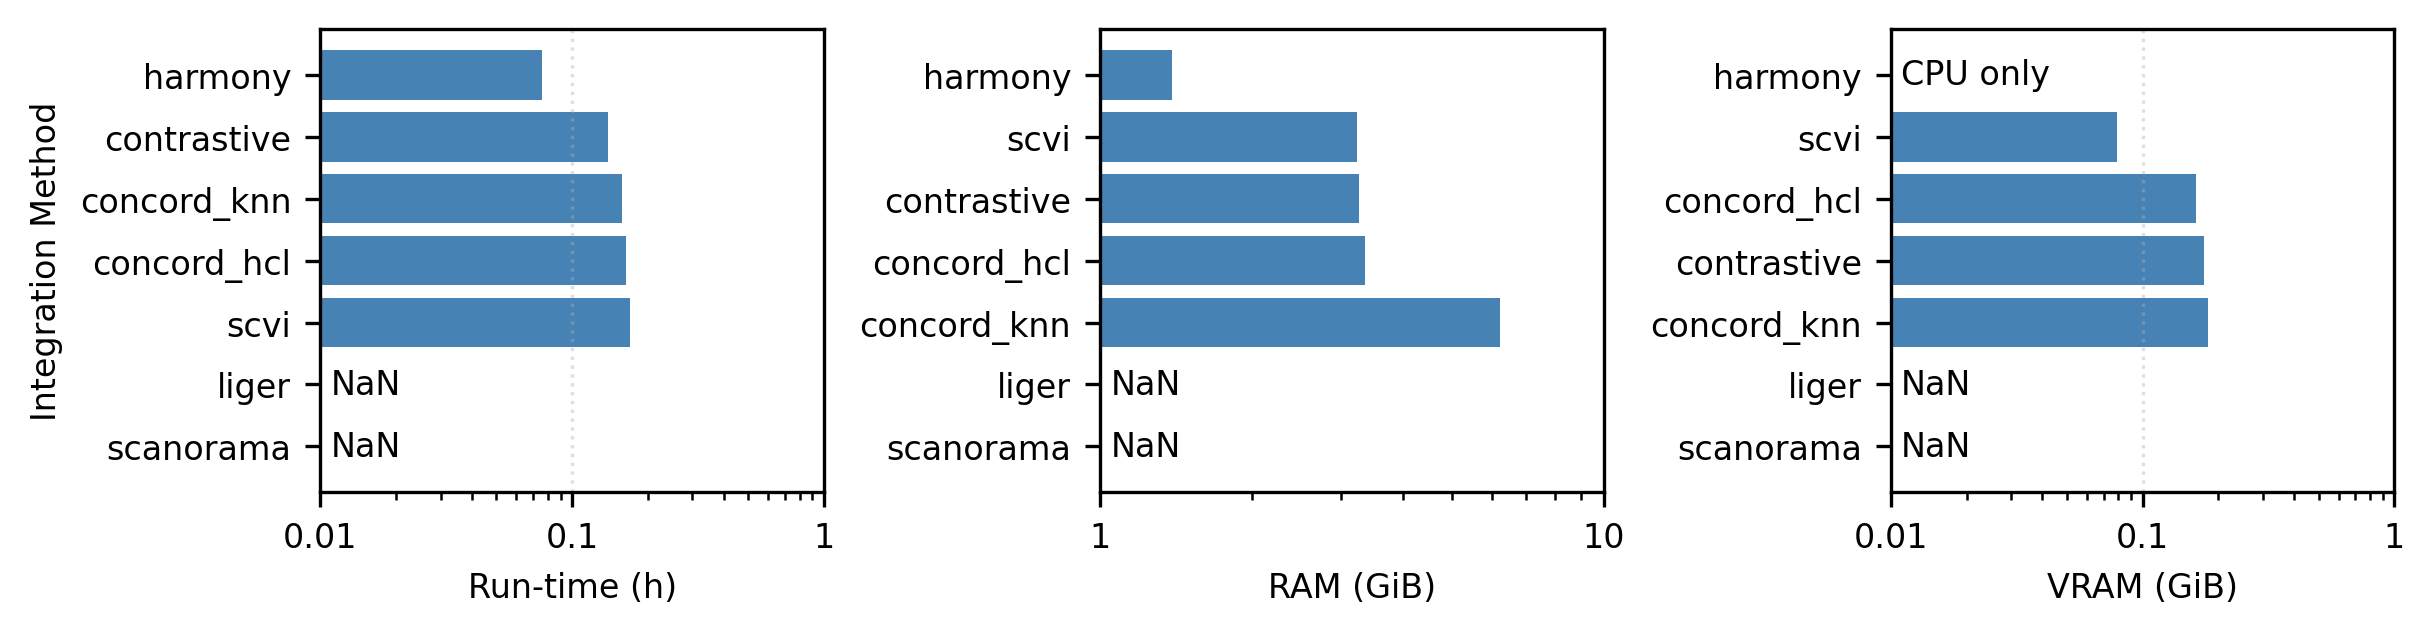

In [67]:
from benchmark_utils import plot_benchmark_performance
with plt.rc_context(rc=custom_rc):
    plot_benchmark_performance(bench_df, figsize=(8,2), dpi=300, 
                               metric_scale = {"time_sec": "log", 
                                               "ram_MB": "log", 
                                               "vram_MB": "log", },
                                unit = "GiB",
                               save_path = save_dir / f"benchmark_plot_log_{file_suffix}.pdf",
                               label_fontsize=8,)

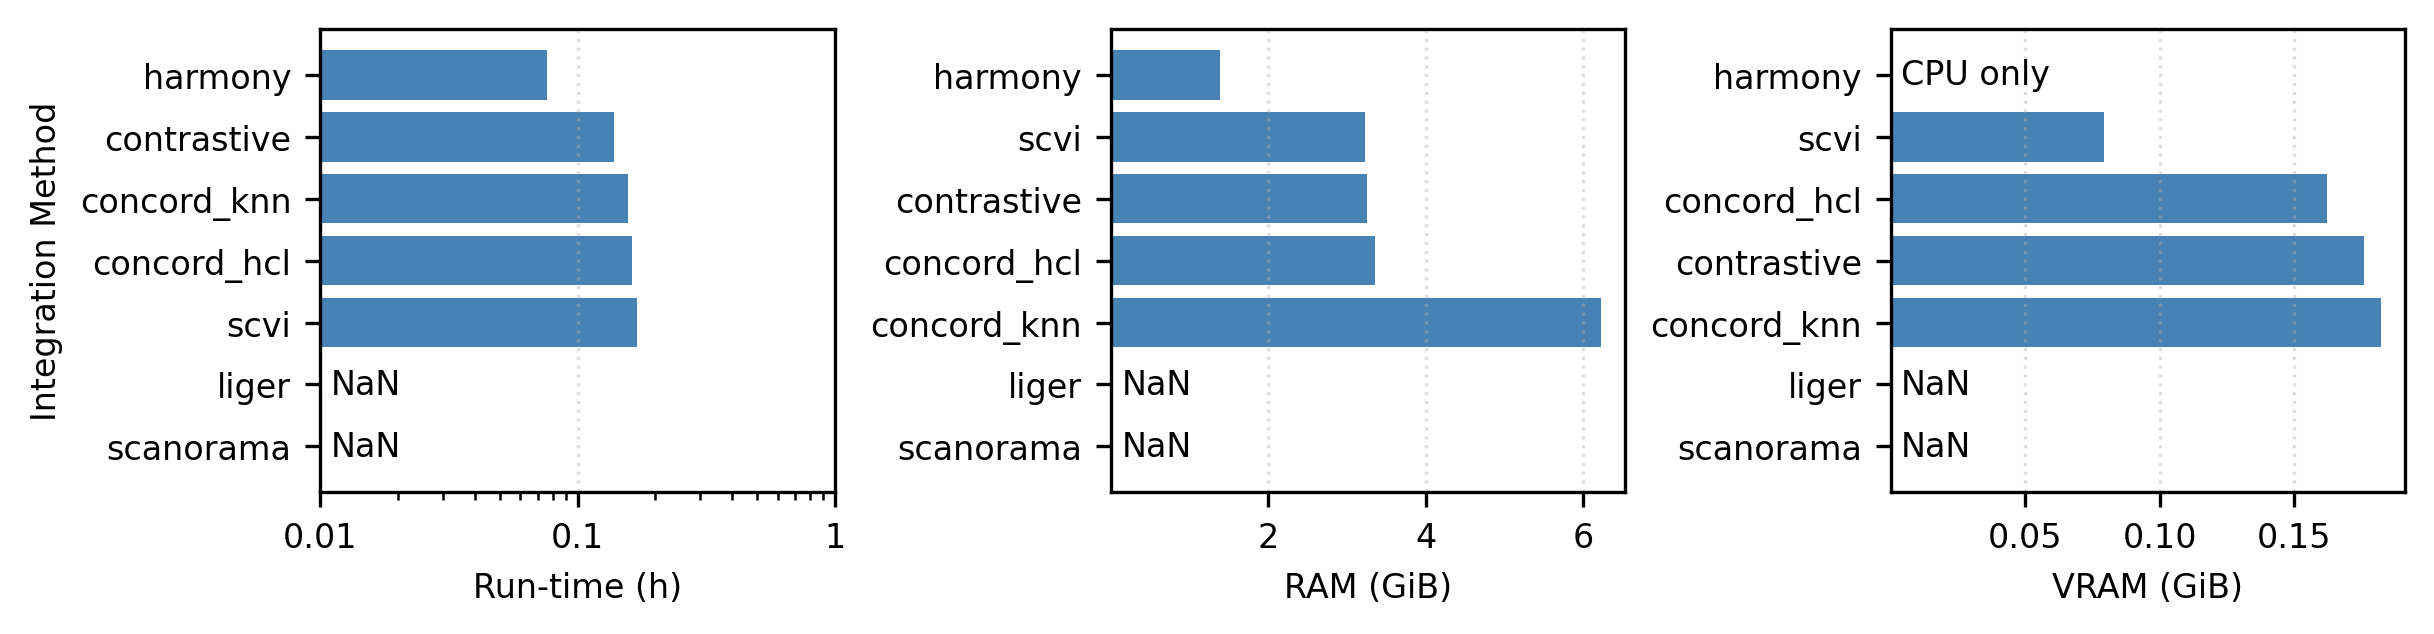

In [71]:
from benchmark_utils import plot_benchmark_performance
with plt.rc_context(rc=custom_rc):
    plot_benchmark_performance(bench_df, figsize=(8,2), dpi=300, 
                               metric_scale = {"time_sec": "log", 
                                               "ram_MB": "linear", 
                                               "vram_MB": "linear", },
                                unit = "GiB",
                            #    save_path = save_dir / f"benchmark_plot_log_{file_suffix}.pdf",
                               label_fontsize=8,)

----

# UMAP

In [ ]:
methods = ["unintegrated", "harmony", "scvi", "contrastive", "concord_knn", "concord_hcl"]

batch_key = 'donor_assay'
state_key = 'cell_type'

In [ ]:
# plot everything
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
import seaborn as sns

# Set DejaVu Sans as the default font
custom_rc = {
    'font.family': 'DejaVu Sans',  # Set the desired font for this plot
}

show_keys = methods
show_cols = [batch_key, state_key]
basis_types = ['UMAP']

font_size=10
point_size=1
alpha=0.8
ncols = len(show_keys)
figsize=(ncols * 1.5,1.5)
nrows = int(np.ceil(len(show_keys) / ncols))
pal = {}
for key in [batch_key, state_key]:
    n_categories = adata.obs[key].nunique()
    _, _, pal[key] = ccd.pl.get_color_mapping(adata,key, pal='tab20', seed=seed)

with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=show_cols,
        basis_types=basis_types,
        pal=pal,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        save_dir=save_dir,
        file_suffix=file_suffix,
        dpi=600,
        save_format='svg'
    )


In [ ]:
show_basis = 'concord_hcl_UMAP'
show_cols = [batch_key, state_key]

pal = {}
for key in [batch_key, state_key]:
    n_categories = adata.obs[key].nunique()
    _, _, pal[key] = ccd.pl.get_color_mapping(adata,key, pal='tab20', seed=seed)
    
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, pal=pal, figsize=(25,15), dpi=600, ncols=2, font_size=10, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embedding_{show_basis}_{file_suffix}.svg"
)

In [ ]:
show_basis = 'concord_hcl_UMAP'
show_cols = [state_key]

pal = {}
for key in [state_key]:
    n_categories = adata.obs[key].nunique()
    _, _, pal[key] = ccd.pl.get_color_mapping(adata,key, pal='tab20', seed=seed)
    
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, pal=pal, figsize=(25,25), dpi=600, ncols=1, font_size=10, point_size=5, legend_loc=None,
    save_path=save_dir / f"embedding_{show_basis}_{state_key}_{file_suffix}.svg"
)

In [ ]:
show_basis = 'concord_knn_UMAP'
show_cols = [batch_key, state_key]

pal = {}
for key in [batch_key, state_key]:
    n_categories = adata.obs[key].nunique()
    _, _, pal[key] = ccd.pl.get_color_mapping(adata,key, pal='tab20', seed=seed)
    
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, pal=pal, figsize=(25,15), dpi=600, ncols=2, font_size=10, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embedding_{show_basis}_{file_suffix}.svg"
)

In [ ]:
show_basis = 'scvi_UMAP'
show_cols = [batch_key, state_key]

pal = {}
for key in [batch_key, state_key]:
    n_categories = adata.obs[key].nunique()
    _, _, pal[key] = ccd.pl.get_color_mapping(adata,key, pal='tab20', seed=seed)
    
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, pal=pal, figsize=(25,15), dpi=600, ncols=2, font_size=10, point_size=5, legend_loc='on data',
    save_path=save_dir / f"embedding_{show_basis}_{file_suffix}.svg"
)

In [ ]:
adata.obs['broad_cell_class'].value_counts()